In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import pandas as pd
from scipy.integrate import solve_ivp
from joblib import Parallel, delayed
from scipy.integrate import odeint
import math
import random
import itertools
import seaborn as sns

/home/anagha/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
num_of_nodes = 3
possible_initial_conditions = []
l = list(itertools.product([0, 1], repeat=num_of_nodes))
for i in range(len(l)):
    possible_initial_conditions.append(list(l[i]))  
    
possible_initial_conditions = np.array(possible_initial_conditions)                                                           



In [3]:
def update_states(states, adjacency_matrix):
    states = np.array(states)
    new_states = []

    for i in range(len(states)):
        input_sum = np.dot(adjacency_matrix[i], states)

        if input_sum < 0:
            new_states.append(0)
        elif input_sum > 0:
            new_states.append(1)
            
        else:
            new_states.append(states[i])  

    return new_states


#-------------------------------------------------------------------------------------------------------------

def run_simulation(initial_states, adjacency_matrix, max_iterations=20):
    states = initial_states[:]
    history = [states]

    for interation in range(max_iterations):
        new_states = update_states(states, adjacency_matrix)
        history.append(new_states)
        states = new_states

    return history
#-----------------------------------------------------------------------------------------------------

def all_attractors(adjacency_matrix):
    fixed_point_set = set()
    cycle_set = set()

    for i in range(len(possible_initial_conditions)):
        history = run_simulation(list(possible_initial_conditions[i, :]), adjacency_matrix)

        for cycle_len in range(1, len(history) // 2 + 1):
            if history[-cycle_len:] == history[-2 * cycle_len:-cycle_len]:
                if cycle_len == 1:
                    fixed_point_set.add(tuple(history[-1]))  
                else:
                    cycle = tuple(tuple(state) for state in history[-cycle_len:])
                    cycle_set.add(cycle)
                break 

    
    result = []

    for fp in fixed_point_set:
        result.append({
            "type": "fixed_point",
            "state": list(fp)
        })

    for cyc in cycle_set:
        result.append({
            "type": "cycle",
            "length": len(cyc),
            "states": [list(state) for state in cyc]
        })

    return result



In [4]:
results = []
all_combinations = list(itertools.product([-1, 0, 1], repeat=9))
for combination in all_combinations:
    adjacency_matrix_used = np.array(combination).reshape(3, 3)
    result_array = all_attractors(adjacency_matrix_used)
    results.append(result_array)


In [13]:
#adjacnecy matrices that get can reach an oscillator
matching_indices = []

for index, sublist in enumerate(results):
    for d in sublist:
        if (d.get("type") == "cycle" ):
            if d.get("length") == 6:
                matching_indices.append(index)
                break
print(len(matching_indices))
matching_indices

2


[8593, 11089]

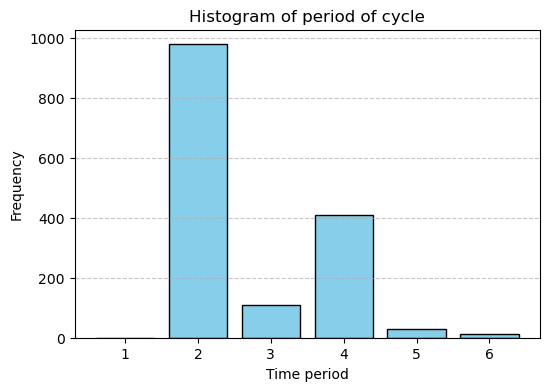

In [23]:


cycle_lengths = []

for attractor_list in results:
    for attractor in attractor_list:
        if attractor.get('type') == 'cycle':
            cycle_lengths.append(attractor.get('length'))


plt.figure(figsize=(6, 4))
plt.hist(cycle_lengths, bins=range(1, max(cycle_lengths) + 2), align='left', rwidth=0.8,
         color='skyblue', edgecolor='black')
plt.xlabel('Time period')
plt.ylabel('Frequency')
plt.title('Histogram of period of cycle')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [16]:
print(type(results))
print(type(results[0]))
print(results[0])

<class 'list'>
<class 'list'>
[{'type': 'fixed_point', 'state': [0, 0, 0]}]


In [43]:
this_combiantion = all_combinations[5691]
np.array(this_combiantion).reshape(3, 3)

array([[-1,  1,  0],
       [ 1,  0, -1],
       [ 1,  0, -1]])

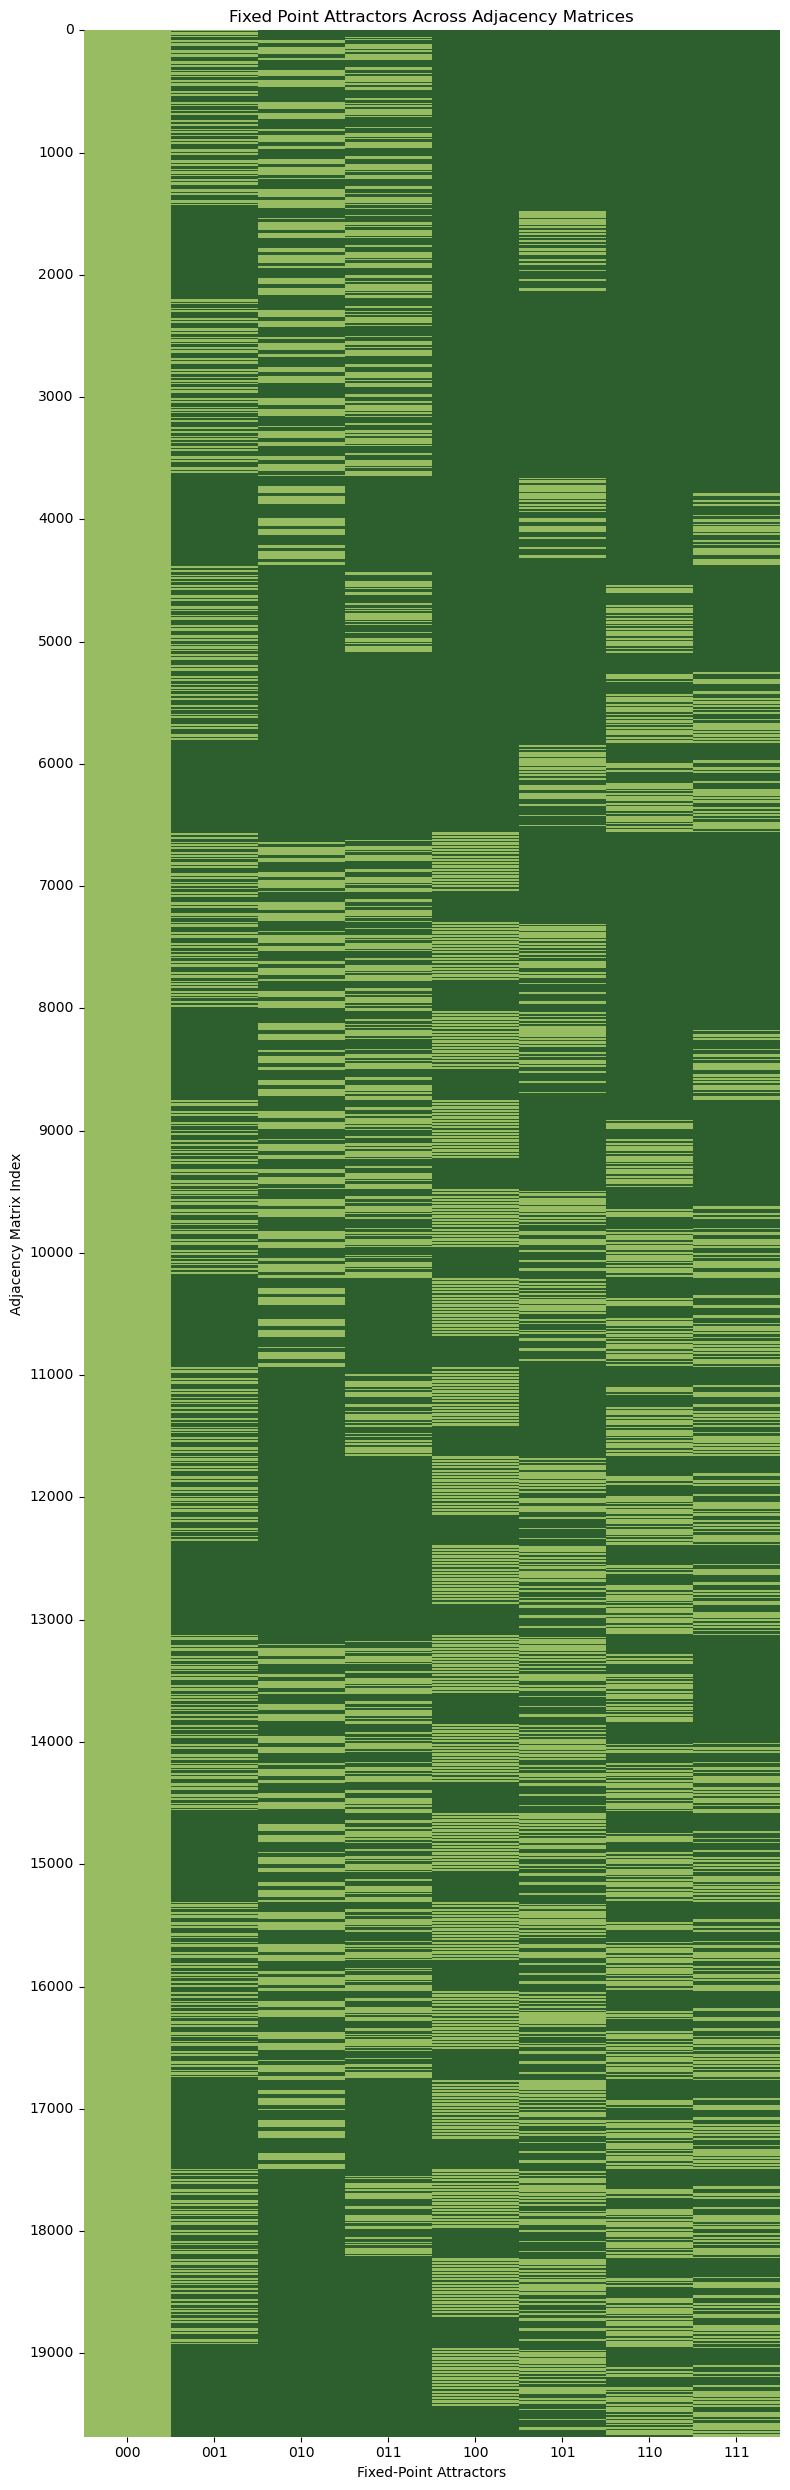

In [8]:


# heat map shwoing all attratcors and all possible adj matrices

attractor_labels = ['000', '001', '010', '011', '100', '101', '110', '111']
label_to_index = {label: i for i, label in enumerate(attractor_labels)}


cmap = ListedColormap(['#2C5F2D', '#97BC62'])


heatmap_data = np.zeros((len(results), 8))


for matrix_idx, attractor_list in enumerate(results):
    for attractor in attractor_list:
        if attractor['type'] == 'fixed_point':
            binary_str = ''.join(str(x) for x in attractor['state'])
            if binary_str in label_to_index:
                col_idx = label_to_index[binary_str]
                heatmap_data[matrix_idx][col_idx] = 1


tick_interval = 1000
yticks = np.arange(0, heatmap_data.shape[0], tick_interval)
ytick_labels = [str(i) for i in yticks]


plt.figure(figsize=(8, 25)) 
sns.heatmap(
    heatmap_data,
    cmap=cmap,
    cbar=False,
    xticklabels=attractor_labels,
    yticklabels=ytick_labels
)
plt.yticks(ticks=yticks + 0.5, labels=ytick_labels, rotation=0)  
plt.xlabel("Fixed-Point Attractors")
plt.ylabel("Adjacency Matrix Index")
plt.title("Fixed Point Attractors Across Adjacency Matrices")
plt.tight_layout()
plt.show()


In [15]:
# number of matrices with 8 attractors. Wow! those exist.
full_fixed_point_matrices = []
counter = 0
for i in range(len(results)):
    fixed_attractors = set()
    
    for attractor in results[i]:
        if attractor['type'] == 'fixed_point':
            binary_str = ''.join(str(x) for x in attractor['state'])
            fixed_attractors.add(binary_str)
    
    if len(fixed_attractors) == 8:
        counter += 1
        #print(i)
        full_fixed_point_matrices.append(i)
print(counter)

64


In [12]:
# number of matrices that are caplable of producing all 4 colours
group_A = {'101', '111'}
group_B = {'100', '110'}
group_C = {'010', '011'}
group_D = {'000', '001'}

matching_indices = []

for idx, matrix_result in enumerate(results):
    
    
    attractor_strings = set()

    for a in matrix_result:
        if a['type'] == 'fixed_point':
            state = a['state']
            binary_str = ''
            for bit in state:
                binary_str += str(bit)
            attractor_strings.add(binary_str)
   
    if (
        attractor_strings & group_A and
        attractor_strings & group_B and
        attractor_strings & group_C and
        attractor_strings & group_D
    ):
        matching_indices.append(idx)


print(len(matching_indices))

1992


In [13]:
# the matrices that map only to groups D an something else.Always maps to D becuase of our updation rule.

group_A = {'101', '111'}
group_B = {'100', '110'}
group_C = {'010', '011'}
group_D = {'000', '001'}

matching_indices_with_group = []

for idx, matrix_result in enumerate(results):
    attractor_strings = set()

    for a in matrix_result:
        if a['type'] == 'fixed_point':
            state = a['state']
            binary_str = ''.join(str(bit) for bit in state)
            attractor_strings.add(binary_str)

    matches = {}

    # First loop: build the matches dict
    for group_name, group_set in zip(['A', 'B', 'C', 'D'], [group_A, group_B, group_C, group_D]):
        matches[group_name] = bool(attractor_strings & group_set)

    # Second loop: collect matched groups
    matched_groups = []
    for group in matches:
        if matches[group]:
            matched_groups.append(group)

    if len(matched_groups) == 2:
        matching_indices_with_group.append((idx, matched_groups[0], matched_groups[1]))

print(matching_indices_with_group)

[(56, 'C', 'D'), (58, 'C', 'D'), (59, 'C', 'D'), (60, 'C', 'D'), (61, 'C', 'D'), (62, 'C', 'D'), (65, 'C', 'D'), (67, 'C', 'D'), (68, 'C', 'D'), (69, 'C', 'D'), (70, 'C', 'D'), (71, 'C', 'D'), (74, 'C', 'D'), (76, 'C', 'D'), (77, 'C', 'D'), (78, 'C', 'D'), (79, 'C', 'D'), (80, 'C', 'D'), (81, 'C', 'D'), (82, 'C', 'D'), (83, 'C', 'D'), (84, 'C', 'D'), (85, 'C', 'D'), (86, 'C', 'D'), (90, 'C', 'D'), (91, 'C', 'D'), (92, 'C', 'D'), (93, 'C', 'D'), (94, 'C', 'D'), (95, 'C', 'D'), (99, 'C', 'D'), (100, 'C', 'D'), (101, 'C', 'D'), (102, 'C', 'D'), (103, 'C', 'D'), (104, 'C', 'D'), (108, 'C', 'D'), (109, 'C', 'D'), (110, 'C', 'D'), (111, 'C', 'D'), (112, 'C', 'D'), (113, 'C', 'D'), (114, 'C', 'D'), (115, 'C', 'D'), (116, 'C', 'D'), (117, 'C', 'D'), (118, 'C', 'D'), (119, 'C', 'D'), (120, 'C', 'D'), (121, 'C', 'D'), (122, 'C', 'D'), (123, 'C', 'D'), (124, 'C', 'D'), (125, 'C', 'D'), (126, 'C', 'D'), (127, 'C', 'D'), (128, 'C', 'D'), (129, 'C', 'D'), (130, 'C', 'D'), (131, 'C', 'D'), (132, 'C',

In [17]:
index_of_interesting_matrix = 2207
print(results[index_of_interesting_matrix])
this_combiantion = all_combinations[index_of_interesting_matrix]
np.array(this_combiantion).reshape(3, 3)

[{'type': 'fixed_point', 'state': [0, 0, 0]}, {'type': 'fixed_point', 'state': [0, 0, 1]}]


array([[-1,  0, -1],
       [-1, -1, -1],
       [ 1, -1,  1]])

In [16]:
# finding neighbours (1 edge difference matrices) that switch to specific colours.
def generate_one_edge_mutants(matrix):
    mutants = []
    matrix = np.array(matrix)

    for i in range(3):
        for j in range(3):
            current_val = matrix[i, j]
            for new_val in [-1, 0, 1]:
                if new_val != current_val:
                    mutated = matrix.copy()
                    mutated[i, j] = new_val
                    mutants.append(mutated.tolist())
    return mutants

def filter_mutants_by_attractor(mutants, target_state):
    matching = []

    for mutant in mutants:
        attractors = all_attractors(mutant)

        # Check if *all* attractors are a single fixed point and it's equal to target
        if len(attractors) == 1 and attractors[0]["type"] == "fixed_point":
            if attractors[0]["state"] == target_state:
                matching.append(mutant)

    return matching


In [19]:
target_state = [0, 0, 0]

# Your original matrix
original_matrix = [
    [0, 1, 0],
    [-1, 0, 1],
    [1, 0, 0]
]

mutants = generate_one_edge_mutants(original_matrix)
good_mutants = filter_mutants_by_attractor(mutants, target_state)

print(f"{len(good_mutants)} mutants found that exclusively go to {target_state}")


0 mutants found that exclusively go to [0, 0, 0]


In [17]:
def is_state_in_groups(state, allowed_groups):
    state_str = ''.join(str(bit) for bit in state)
    return any(state_str in group for group in allowed_groups)

def filter_mutants_by_allowed_groups(mutants, allowed_groups):
    matching = []

    for mutant in mutants:
        attractors = all_attractors(mutant)

        valid = True
        for attractor in attractors:
            if attractor["type"] == "fixed_point":
                if not is_state_in_groups(attractor["state"], allowed_groups):
                    valid = False
                    break
            elif attractor["type"] == "cycle":
                for s in attractor["states"]:
                    if not is_state_in_groups(s, allowed_groups):
                        valid = False
                        break
            if not valid:
                break

        if valid:
            matching.append(mutant)

    return matching


In [24]:
group_A = {'101', '111'}
group_B = {'100', '110'}
group_C = {'010', '011'}
group_D = {'000', '001'}

allowed_groups = [group_A, group_D]

good_mutants = filter_mutants_by_allowed_groups(mutants, allowed_groups)

all_attractors(good_mutants[1])

[{'type': 'fixed_point', 'state': [0, 0, 0]},
 {'type': 'fixed_point', 'state': [1, 0, 1]},
 {'type': 'fixed_point', 'state': [1, 1, 1]}]

In [14]:

plt.figure(figsize=(8, 4))
sns.histplot(
    cycle_lengths,
    bins=range(1, max(cycle_lengths)+2),  
    color="#DE8173",
    edgecolor='black',
    discrete=True 
)
plt.xlabel("Cycle Length")
plt.ylabel("Number of Cycles")
plt.title("Distribution of Cycle Lengths")
plt.tight_layout()
plt.show()


NameError: name 'cycle_lengths' is not defined

<Figure size 800x400 with 0 Axes>

Stochastic swicthing of states.

In [39]:
p_01 = [0.4, 0.4, 0.4]  # Probabilities for 0 → 1
p_10 = [0.1, 0.2, 0.05]    # Probabilities for 1 → 0


In [40]:
def update_states(states, adjacency_matrix, p_01, p_10):
    new_states = [0] * len(states)

    # Deterministic update
    for i in range(len(states)):
        influence = 0
        for j in range(len(states)):
            influence += adjacency_matrix[i][j] * states[j]
        new_states[i] = 1 if influence > 0 else 0

    # Stochastic flipping
    for i in range(len(new_states)):
        if new_states[i] == 0 and random.random() < p_01[i]:
            new_states[i] = 1
        elif new_states[i] == 1 and random.random() < p_10[i]:
            new_states[i] = 0

    return new_states



#------------------------------------------------------------------------------------------------
def run_simulation(initial_state, adjacency_matrix, p_01, p_10, max_steps=100):
    history = [initial_state]
    current_state = initial_state.copy()

    for _ in range(max_steps):
        new_state = update_states(current_state, adjacency_matrix, p_01, p_10)
        history.append(new_state)

        if new_state == current_state:
            break

        current_state = new_state

    return history

def all_attractors(adjacency_matrix, p_01, p_10, max_steps=100):
    all_histories = []

    for initial_state in possible_initial_conditions:
        history = run_simulation(list(initial_state), adjacency_matrix, p_01, p_10, max_steps)
        all_histories.append(history)

    return all_histories


#-------------------------------------
def get_adj_matrix_by_index(index):
    all_combinations = list(itertools.product([-1, 0, 1], repeat=9))
    return np.array(all_combinations[index]).reshape(3, 3)


In [52]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def animate_history(history):
    fig, ax = plt.subplots()
    square = plt.Rectangle((0, 0), 1, 1, facecolor='white')
    ax.add_patch(square)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

    def update(frame):
        state = history[frame]
        binary_str = ''.join(str(bit) for bit in state)
        group = state_to_group(binary_str)
        square.set_facecolor(group_colors[group])
        return [square]

    ani = animation.FuncAnimation(
        fig, update,
        frames=len(history),
        interval=500,
        blit=False,
        repeat=False
    )

    plt.title("Simulation Animation")
    plt.show()
    return ani  # ✅ THIS IS IMPORTANT


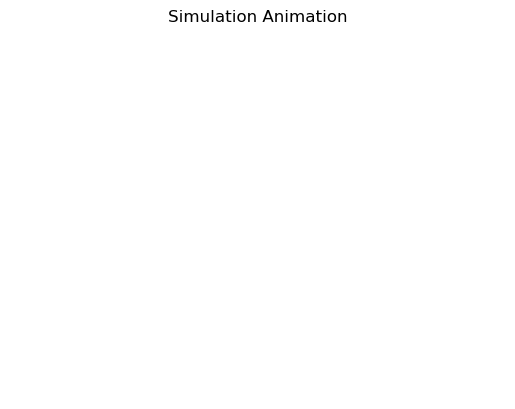

In [53]:
history = run_simulation([0, 0, 0], adj_matrix, p_01, p_10)
ani = animate_history(history)  # ✅ STORE it in a variable


<IPython.core.display.Javascript object>


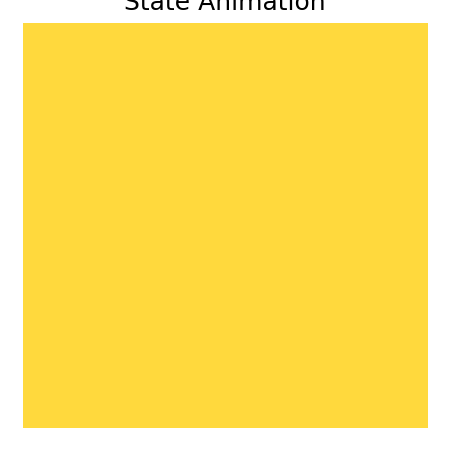

In [61]:

initial_state = [0, 1, 1]
adj_matrix = get_adj_matrix_by_index(2207)
history = run_simulation(initial_state, adj_matrix, p_01, p_10)
ani = animate_history(history)

In [59]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def animate_history(history):
    fig, ax = plt.subplots(figsize=(3, 3))
    square = plt.Rectangle((0, 0), 1, 1, facecolor='white')
    ax.add_patch(square)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    ax.axis('off')

    def update(frame):
        state = history[frame]
        binary_str = ''.join(str(bit) for bit in state)
        group = state_to_group(binary_str)
        square.set_facecolor(group_colors[group])
        return [square]

    ani = animation.FuncAnimation(
        fig, update,
        frames=len(history),     # ✅ One frame per simulation step
        interval=200,            # ✅ Controls speed
        blit=False,
        repeat=False
    )

    plt.tight_layout()
    plt.title("State Animation")
    plt.show()
    return ani


In [55]:

%matplotlib notebook

<IPython.core.display.Javascript object>


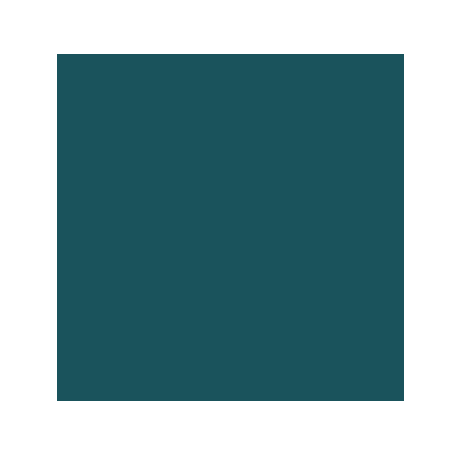

In [63]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation

history = [
    [0, 0, 0],  # D
    [0, 1, 0],  # C
    [1, 0, 0],  # B
    [1, 1, 1],  # A
    [0, 1, 1],  # C
    [0, 0, 1],  # D
]

group_A = {'101', '111'}
group_B = {'100', '110'}
group_C = {'010', '011'}
group_D = {'000', '001'}

group_colors = {
    'A': '#FF6B6B',
    'B': '#4ECDC4',
    'C': '#FFD93D',
    'D': '#1A535C',
    'none': '#DDDDDD'
}

def state_to_group(binary_str):
    if binary_str in group_A:
        return 'A'
    elif binary_str in group_B:
        return 'B'
    elif binary_str in group_C:
        return 'C'
    elif binary_str in group_D:
        return 'D'
    else:
        return 'none'

def animate_history(history):
    fig, ax = plt.subplots(figsize=(3, 3))
    square = plt.Rectangle((0, 0), 1, 1, facecolor='white')
    ax.add_patch(square)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    ax.axis('off')

    def update(frame):
        state = history[frame]
        binary_str = ''.join(str(bit) for bit in state)
        group = state_to_group(binary_str)
        square.set_facecolor(group_colors[group])
        return [square]

    ani = animation.FuncAnimation(
        fig, update,
        frames=len(history),
        interval=500,
        blit=False,
        repeat=False
    )
    return ani

ani = animate_history(history)


In [65]:
%matplotlib notebook


<IPython.core.display.Javascript object>


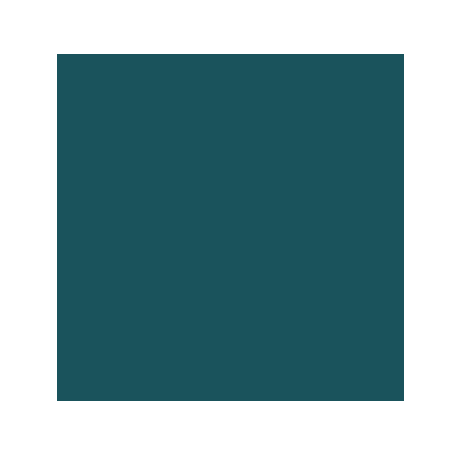

In [67]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Dummy simulation history (replace this with your actual one!)
history = [
    [0, 0, 0],  # D
    [0, 1, 0],  # C
    [1, 0, 0],  # B
    [1, 1, 1],  # A
    [0, 1, 1],  # C
    [0, 0, 1],  # D
]

# Define groups
group_A = {'101', '111'}
group_B = {'100', '110'}
group_C = {'010', '011'}
group_D = {'000', '001'}

# Assign colors to groups
group_colors = {
    'A': '#FF6B6B',   # red
    'B': '#4ECDC4',   # teal
    'C': '#FFD93D',   # yellow
    'D': '#1A535C',   # blue
    'none': '#DDDDDD' # grey
}

# Helper: binary state to group
def state_to_group(binary_str):
    if binary_str in group_A:
        return 'A'
    elif binary_str in group_B:
        return 'B'
    elif binary_str in group_C:
        return 'C'
    elif binary_str in group_D:
        return 'D'
    else:
        return 'none'

# Animate it
def animate_history(history):
    fig, ax = plt.subplots(figsize=(3, 3))
    square = plt.Rectangle((0, 0), 1, 1, facecolor='white')
    ax.add_patch(square)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    ax.axis('off')

    def update(frame):
        state = history[frame]
        binary_str = ''.join(str(bit) for bit in state)
        group = state_to_group(binary_str)
        square.set_facecolor(group_colors[group])
        return [square]

    ani = animation.FuncAnimation(
        fig, update,
        frames=len(history),
        interval=500,
        blit=False,
        repeat=False
    )
    return ani

# Run the animation
ani = animate_history(history)


Different update rule








Go up.



In [11]:
#-------------------------------------------------------------------------------------------

In [10]:
def update_states_majority_gate(states, adjacency_matrix):
    new_states = [0] * len(states)

    for j in range(len(states)):
        input_sum = 0
        for i in range(len(states)):
            connection = adjacency_matrix[i][j]
            if connection == 1:
                input_sum += states[i]
            elif connection == -1:
                input_sum += int(not states[i])
            # if 0, it does not change the input sum

        
        new_states[j] = 1 if input_sum > 1 else 0

    return new_states

#----------------------------------------------------------------------------------------------

def run_simulation_majority_gate(initial_states, adjacency_matrix, max_iterations=20):
    states = initial_states[:]
    history = [states]

    for interation in range(max_iterations):
        new_states = update_states_majority_gate(states, adjacency_matrix)
        history.append(new_states)
        states = new_states

    return history
#-----------------------------------------------------------------------------------------------------

def all_attractors_majority_gate(adjacency_matrix):
    fixed_point_set = set()
    cycle_set = set()

    for i in range(len(possible_initial_conditions)):
        history = run_simulation_majority_gate(list(possible_initial_conditions[i, :]), adjacency_matrix)

        for cycle_len in range(1, len(history) // 2 + 1):
            if history[-cycle_len:] == history[-2 * cycle_len:-cycle_len]:
                if cycle_len == 1:
                    fixed_point_set.add(tuple(history[-1]))  
                else:
                    cycle = tuple(tuple(state) for state in history[-cycle_len:])
                    cycle_set.add(cycle)
                break 

    
    result = []

    for fp in fixed_point_set:
        result.append({
            "type": "fixed_point",
            "state": list(fp)
        })

    for cyc in cycle_set:
        result.append({
            "type": "cycle",
            "length": len(cyc),
            "states": [list(state) for state in cyc]
        })

    return result



In [11]:
results_majority_gate = []
all_combinations = list(itertools.product([-1, 0, 1], repeat=9))
for combination in all_combinations:
    adjacency_matrix_used = np.array(combination).reshape(3, 3)
    result_array = all_attractors_majority_gate(adjacency_matrix_used)
    results_majority_gate.append(result_array)


In [18]:

group_A = {'101', '111'}
group_B = {'100', '110'}
group_C = {'010', '011'}
group_D = {'000', '001'}

matching_indices = []

for idx, matrix_result in enumerate(results_majority_gate):
    
    
    attractor_strings = set()

    for a in matrix_result:
        if a['type'] == 'fixed_point':
            state = a['state']
            binary_str = ''
            for bit in state:
                binary_str += str(bit)
            attractor_strings.add(binary_str)
   
    if (
        attractor_strings & group_A and
        attractor_strings & group_B and
        attractor_strings & group_C and
        attractor_strings & group_D
    ):
        matching_indices.append(idx)


print(len(matching_indices))

79

In [20]:

matching_indices = []

for index, sublist in enumerate(results_majority_gate):
    for d in sublist:
        if (d.get("type") == "cycle" ):
            matching_indices.append(index)
            break
print(len(matching_indices))

9671


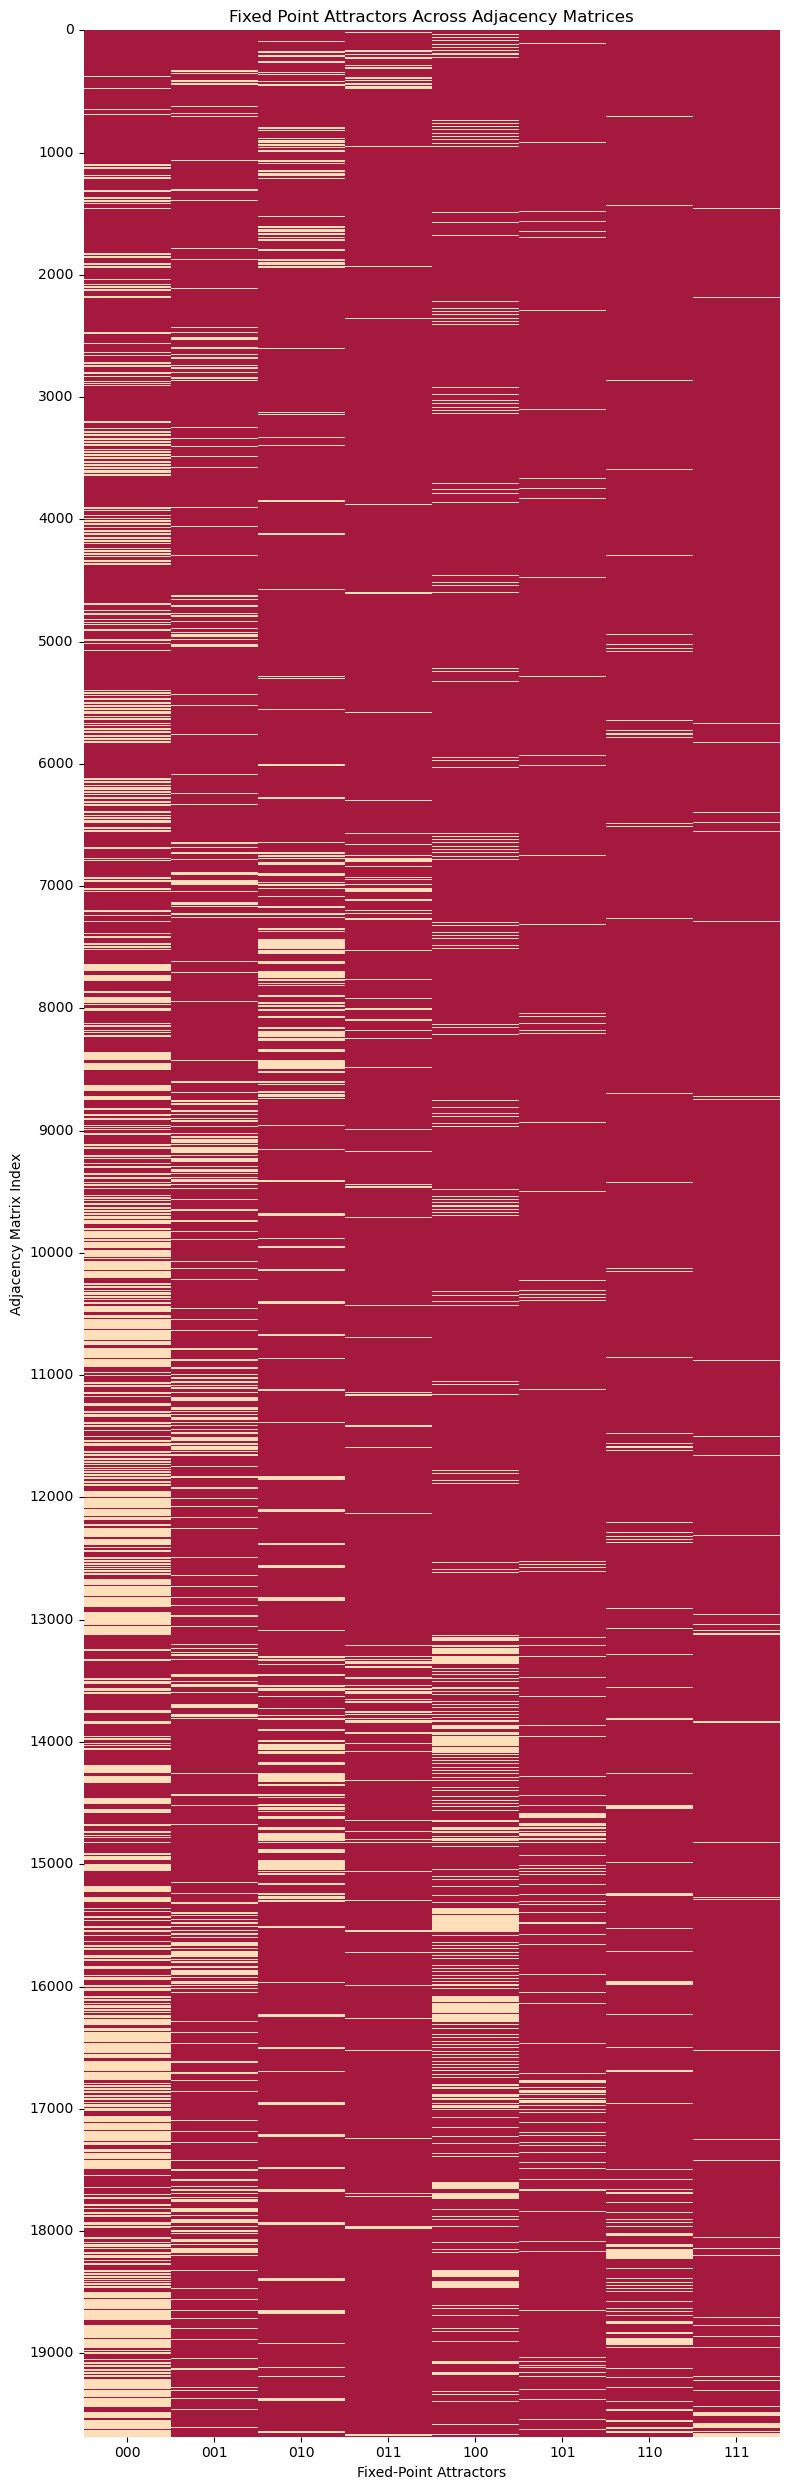

In [13]:




attractor_labels = ['000', '001', '010', '011', '100', '101', '110', '111']
label_to_index = {label: i for i, label in enumerate(attractor_labels)}


cmap = ListedColormap(['#A4193D', '#FFDFB9'])


heatmap_data = np.zeros((len(results_majority_gate), 8))


for matrix_idx, attractor_list in enumerate(results_majority_gate):
    for attractor in attractor_list:
        if attractor['type'] == 'fixed_point':
            binary_str = ''.join(str(x) for x in attractor['state'])
            if binary_str in label_to_index:
                col_idx = label_to_index[binary_str]
                heatmap_data[matrix_idx][col_idx] = 1


tick_interval = 1000
yticks = np.arange(0, heatmap_data.shape[0], tick_interval)
ytick_labels = [str(i) for i in yticks]


plt.figure(figsize=(8, 25)) 
sns.heatmap(
    heatmap_data,
    cmap=cmap,
    cbar=False,
    xticklabels=attractor_labels,
    yticklabels=ytick_labels
)
plt.yticks(ticks=yticks + 0.5, labels=ytick_labels, rotation=0)  
plt.xlabel("Fixed-Point Attractors")
plt.ylabel("Adjacency Matrix Index")
plt.title("Fixed Point Attractors Across Adjacency Matrices")
plt.tight_layout()
plt.show()


In [56]:

full_fixed_point_matrices = []

for i in range(len(results_majority_gate)):
    fixed_attractors = set()
    
    for attractor in results_majority_gate[i]:
        if attractor['type'] == 'fixed_point':
            binary_str = ''.join(str(x) for x in attractor['state'])
            fixed_attractors.add(binary_str)
    
    if len(fixed_attractors) == 8:
        print(i)
        full_fixed_point_matrices.append(i)
